Pro. Fernando Amaral  -  [www.eia.ai](https://www.eia.ai)

In [53]:
#gpu

In [54]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import Layer

In [55]:
# Carregar dados MNIST
(x_train, _), (x_test, _) = mnist.load_data()

In [56]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [57]:
# Hiper parâmetros
batch_size = 100
original_dim = 784
latent_dim = 8
intermediate_dim = 256
epochs = 100
epsilon_std = 1.0

In [58]:
# Encoder
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [59]:
# Função para amostrar do espaço latente
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2 ) * epsilon
# Camada de amostragem
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [60]:
# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [61]:
class CustomLossLayer(Layer): # Create a custom layer
    def call(self, inputs):
        x, x_decoded_mean = inputs
        xent_loss = original_dim * tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
        return xent_loss

class KLLossLayer(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return kl_loss

class vaeLossLayer(Layer):
    def call(self, inputs):
        xent_loss, kl_loss = inputs
        vae_loss = K.mean(xent_loss + kl_loss)
        return vae_loss

In [62]:
# Loss
xent_loss = CustomLossLayer()([x, x_decoded_mean])
kl_loss = KLLossLayer()([z_mean, z_log_var])
vae_loss = vaeLossLayer()([xent_loss, kl_loss])

In [63]:
# Modelo VAE
vae = Model(x, [x_decoded_mean, vae_loss]) # Include vae_loss as an output
vae.compile(optimizer='rmsprop', loss=lambda y_true, y_pred: y_pred[1]) # Define a custom loss function to use the vae_loss output

In [64]:
# Treinar o VAE
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Epoch 1/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0810 - val_loss: 1.2828e-05
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1731e-05 - val_loss: 4.4327e-06
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0490e-05 - val_loss: 2.2034e-06
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.9404e-06 - val_loss: 1.1752e-06
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5892e-06 - val_loss: 1.3978e-06
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.3048e-06 - val_loss: 8.3702e-07
Epoch 7/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0794e-06 - val_loss: 7.3823e-07
Epoch 8/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4932e-06 - val_loss: 5.0080e-07
Epoch 9/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0107e-06 - val_loss: 5.0934e-07
Epoch 10/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.3407e-07 - val_loss: 3.1589e-07
Epoch 11/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [65]:
# Construir o modelo do encoder para mapear entradas para o espaço latente
encoder = Model(x, z_mean)

In [66]:
# Construir o modelo do decodificador
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


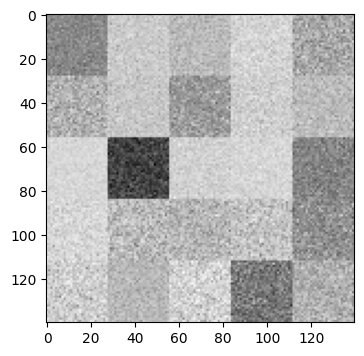

In [67]:
import matplotlib.pyplot as plt

# amostra da distribuição latente normal padrão
n = 5  # 15x15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Gerar digitos
for i in range(n):
  for j in range(n):
    z_sample = np.random.normal(size=(1, latent_dim)) * epsilon_std
    x_decoded = generator.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size,
           j * digit_size: (j + 1) * digit_size ] = digit

plt.figure(figsize=(4, 4))
plt.imshow(figure, cmap='Greys_r')
plt.show()